In [1]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchsparse
import hdbscan
import laspy
import time

from EHydro_TreeUnet.tree_unet import UNet
from pathlib import Path

from torch import nn
from torch.cuda import amp
from torchsparse import SparseTensor
from torchsparse.nn import functional as F
from torch.utils.data import random_split, DataLoader
from torchsparse.utils.collate import sparse_collate_fn
from torchsparse.utils.quantize import sparse_quantize
from torchsparse.utils.collate import sparse_collate_fn as _orig_collate

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
TRAINING = True

DATA_AUGMENTATION_COEF = 1.5
SEMANTIC_LOSS_COEF = 1.0
PARENT_LOSS_COEF = 10.0

In [3]:
class FORinstanceDataset:
    def __init__(self, voxel_size: float) -> None:
        self.voxel_size = voxel_size
        self.folder = Path('./datasets/FORinstance')
        self.extensions = ('.laz', '.las')
        self.files = sorted(
            [f for f in self.folder.rglob("*") if f.is_file() and f.suffix.lower() in self.extensions],
            key=lambda f: f.name
        )

        self.files = [self.files[i % len(self.files)] for i in range(int(len(self.files) * DATA_AUGMENTATION_COEF))]

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return [self._load_file(self.files[i]) for i in range(*idx.indices(len(self)))]
        elif isinstance(idx, int):
            if idx < 0:
                idx += len(self)
            if idx < 0 or idx >= len(self):
                raise IndexError("Index out of range")
            return self._load_file(self.files[idx])
        else:
            raise TypeError("Index must be a slice or an integer")
    
    def _load_file(self, path):
        las = laspy.read(path)

        coords = np.vstack((las.x, las.y, las.z)).transpose()
        coords -= np.min(coords, axis=0, keepdims=True)
        feat = np.vstack((las.intensity, las.return_number, las.number_of_returns)).transpose()
        label = np.array(las.classification)
        instance_ids = np.array(las.treeID)

        mask = label != 3

        coords = coords[mask]
        feat = feat[mask]
        label = label[mask]
        label = np.where(label > 3, label - 1, label)
        instance_ids = instance_ids[mask]
            
        coords, indices = sparse_quantize(coords, self.voxel_size, return_index=True)
        feat = feat[indices]
        label = label[indices]
        instance_ids = instance_ids[indices]

        offset = np.zeros((coords.shape[0], 3), dtype=np.float32)
        unique_ids = np.unique(instance_ids)
        for inst_id in unique_ids:
            mask = instance_ids == inst_id
            if not np.any(mask):
                continue

            tree_points = coords[mask]
            offset[mask, :] = tree_points.mean(axis=0) - tree_points

        min_coords = np.min(coords, axis=0)
        max_coords = np.max(coords, axis=0)
        side_lengths = max_coords - min_coords
        volume = np.prod(side_lengths)
        offset /= (volume)

        coords = torch.tensor(coords, dtype=torch.int)
        feat = torch.tensor(feat.astype(np.float32), dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)
        offset = torch.tensor(offset, dtype=torch.float)

        input = SparseTensor(coords=coords, feats=feat)
        label = SparseTensor(coords=coords, feats=label)
        offset = SparseTensor(coords=coords, feats=offset)
        return {"input": input, "label": label, "offset": offset}

    def __len__(self):
        return len(self.files)

In [8]:
colormap = np.array([
    [255, 0, 0],    # clase 0 - Unclassified - rojo
    [0, 255, 0],    # clase 1 - Low-vegetation - verde
    [128, 128, 128],# clase 2 - Terrain - gris
    [255, 165, 0],  # clase 3 - Stem - naranja
    [0, 128, 0],  # clase 4 - Live-branches - verde oscuro
    [0, 0, 255]     # clase 5 - Woody-branches - azul
], dtype=np.uint8)

def draw_pc(coords, labels, ids):
    pcd = o3d.geometry.PointCloud()

    colors = colormap[labels]
    colors = colors / 255.0
    
    pcd.points = o3d.utility.Vector3dVector(coords)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    o3d.visualization.draw_geometries([pcd])

    mask = (labels > 2)
    labels = labels[mask]
    coords = coords[mask]
    ids = ids[mask]
    
    unique_ids = np.unique(ids)
    n_instances = len(unique_ids)

    cmap = plt.get_cmap("tab20")  # Puedes cambiar a 'tab10', 'gist_ncar', etc.
    colors = np.array([cmap(i % 20)[:3] for i in range(n_instances)])

    id2color = {id_: colors[i] for i, id_ in enumerate(unique_ids)}
    point_colors = np.array([id2color[id_] for id_ in ids])

    pcd.points = o3d.utility.Vector3dVector(coords)
    pcd.colors = o3d.utility.Vector3dVector(point_colors)
    o3d.visualization.draw_geometries([pcd])

[step 1] loss = 3.5327067375183105
[step 2] loss = 3.603424072265625
[step 3] loss = 6.009729385375977
[step 4] loss = 6.053499221801758
[step 5] loss = 2.965404510498047
[step 6] loss = 1.883170485496521
[step 7] loss = 1.74480140209198
[step 8] loss = 1.6413804292678833
[step 9] loss = 1.4251773357391357
[step 10] loss = 1.4173051118850708
[step 11] loss = 1.623674988746643
[step 12] loss = 1.2158738374710083
[step 13] loss = 1.3250008821487427
[step 14] loss = 1.2893648147583008
[step 15] loss = 1.1817084550857544
[step 16] loss = 1.1076140403747559
[step 17] loss = 1.256899118423462
[step 18] loss = 0.9495001435279846
[step 19] loss = 0.9443036317825317
[step 20] loss = 0.9393430352210999
[step 21] loss = 1.0653657913208008
[step 22] loss = 0.8283047080039978
[step 23] loss = 0.8319452404975891
[step 24] loss = 0.8693264722824097
[step 25] loss = 1.0856266021728516
[step 26] loss = 0.8290587067604065
[step 27] loss = 0.8071680665016174
[step 28] loss = 0.7568038105964661
[step 29] 

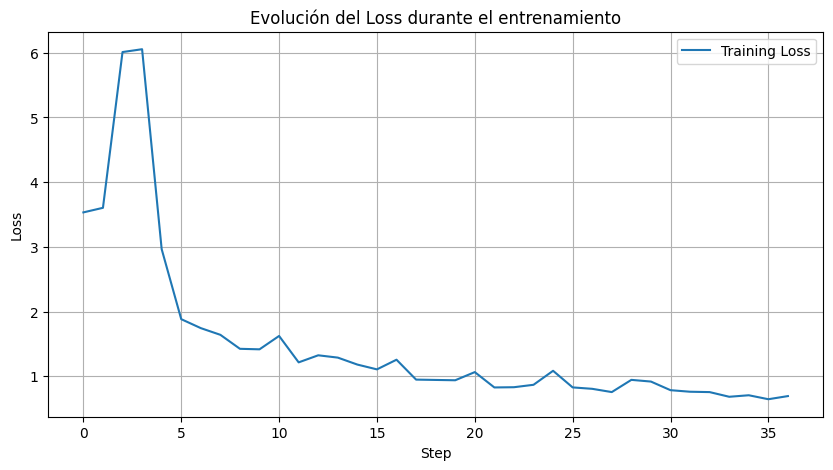

In [5]:
conv_config = F.conv_config.get_default_conv_config(conv_mode=F.get_conv_mode())
conv_config.kmap_mode = 'hashmap'
F.conv_config.set_global_conv_config(conv_config)

model = UNet(3, 6).to(device='cuda')

dataset = FORinstanceDataset(voxel_size=0.2)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=1, collate_fn=sparse_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=sparse_collate_fn)

criterion_semantic = nn.CrossEntropyLoss()
criterion_offset = nn.MSELoss(reduction='none')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scaler = amp.GradScaler(enabled=True)
losses = []

def compute_loss(semantic_output, semantic_labels, offset_output, offset_labels):
    loss_sem = criterion_semantic(semantic_output, semantic_labels)
    
    mask_float = (semantic_labels > 2).float().unsqueeze(1)
    loss_off = criterion_offset(offset_output, offset_labels)
    loss_off = (loss_off * mask_float).mean()
    
    return SEMANTIC_LOSS_COEF * loss_sem + PARENT_LOSS_COEF * loss_off

for k, feed_dict in enumerate(train_loader):
    inputs = feed_dict["input"].to(device='cuda')
    label = feed_dict["label"].to(device='cuda')
    offset = feed_dict["offset"].to(device='cuda')

    with amp.autocast(enabled=True):
        semantic_output, offset_output = model(inputs)
        loss = compute_loss(semantic_output.F, label.F, offset_output.F, offset.F)

    print(f"[step {k + 1}] loss = {loss.item()}")
    losses.append(loss.item())

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

plt.figure(figsize=(10, 5))
plt.plot(losses, label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Evolución del Loss durante el entrenamiento")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# enable torchsparse 2.0 inference
model.eval()
# enable fused and locality-aware memory access optimization
torchsparse.backends.benchmark = True  # type: ignore

clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
with torch.no_grad():
    for k, feed_dict in enumerate(val_loader):
        inputs = feed_dict["input"].to(device='cuda')
        label = feed_dict["label"].to(device='cuda')
        offset = feed_dict["offset"].to(device='cuda')

        coords = inputs.coords[:, 1:].cpu().numpy()
        semantic = label.feats.cpu().numpy()
        offset_ = offset.feats.cpu().numpy()

        min_coords = np.min(coords, axis=0)
        max_coords = np.max(coords, axis=0)
        side_lengths = max_coords - min_coords
        volume = np.prod(side_lengths)

        collapsed_coords = coords + (offset_ * volume)
        id = clusterer.fit_predict(collapsed_coords)

        draw_pc(collapsed_coords, semantic, id)

        with amp.autocast(enabled=True):
            now = time.time()
            semantic_output, offset_output = model(inputs)
            print(f'duracion: {(time.time() - now):.2f} s')

            loss = compute_loss(semantic_output.F, label.F, offset_output.F, offset.F)

            coords = semantic_output.coords[:, 1:].cpu().numpy()
            semantic = semantic_output.feats.cpu()
            offset = offset_output.feats.cpu().numpy()
            label = torch.argmax(semantic, dim=1).numpy()

            min_coords = np.min(coords, axis=0)
            max_coords = np.max(coords, axis=0)
            side_lengths = max_coords - min_coords
            volume = np.prod(side_lengths)
            offset = offset * (volume)

            collapsed_coords = coords + offset
            id = clusterer.fit_predict(collapsed_coords)

            draw_pc(collapsed_coords, label, id)

        print(f"[inference step {k + 1}] loss = {loss.item()}")

duracion: 0.05 s
[inference step 1] loss = 1.2311404943466187
duracion: 0.05 s
[inference step 2] loss = 0.6646103262901306
duracion: 0.37 s
[inference step 3] loss = 12.167128562927246


Process LokyProcess-12:
Process LokyProcess-11:
Process LokyProcess-10:
Process LokyProcess-9:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/samuel/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 450, in _process_worker
    is_clean = worker_exit_lock.acquire(True, timeout=30)
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/samuel/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 450, in _process_worker
    is_clean = worker_exit_lock.acquire(True, timeout=30)
KeyboardInterru

KeyboardInterrupt: 